In [0]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# !mkdir -p Drive
# !google-drive-ocamlfuse Drive

In [2]:
from google.colab import drive
drive.mount('/content/Drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/Drive


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from itertools import product

os.chdir('/content/Drive/My Drive/Colab Notebooks/2019_AI_CUP_LABELING/labeling_cowork_folder')
os.getcwd()

'/content/Drive/My Drive/Colab Notebooks/2019_AI_CUP_LABELING/labeling_cowork_folder'

# Runtime Environment  
* python >= 3.6
* pytorch >= 1.0
* pandas
* nltk
* numpy
* sklearn
* pickle
* tqdm
* json

# Data processing

## 刪除多於資訊 (Remove redundant information)  
我們在資料集中保留了許多額外資訊供大家使用，但是在這次的教學中我們並沒有用到全部資訊，因此先將多餘的部分先抽走。  
In dataset, we reserved lots of information. But in this tutorial, we don't need them, so we need to discard them.

In [4]:
import pandas as pd

dataset = pd.read_csv('raw_data/task1_trainset.csv', dtype=str)
dataset.head()

,Id,Title,Abstract,Authors,Categories,Created Date,Task 1
0,D00001,A Brain-Inspired Trust Management Model to Ass...,Rapid popularity of Internet of Things (IoT) a...,Mahmud/Kaiser/Rahman/Rahman/Shabut/Al-Mamun/Hu...,cs.CR/cs.AI/q-bio.NC,2018-01-11,BACKGROUND OBJECTIVES METHODS METHODS RESULTS ...
1,D00002,On Efficient Computation of Shortest Dubins Pa...,"In this paper, we address the problem of compu...",Sadeghi/Smith,cs.SY/cs.RO/math.OC,2016-09-21,OBJECTIVES OTHERS METHODS/RESULTS RESULTS RESULTS
2,D00003,Data-driven Upsampling of Point Clouds,High quality upsampling of sparse 3D point clo...,Zhang/Jiang/Yang/Yamakawa/Shimada/Kara,cs.CV,2018-07-07,BACKGROUND OBJECTIVES METHODS METHODS METHODS ...
3,D00004,Accessibility or Usability of InteractSE? A He...,Internet is the main source of information now...,Aqle/Khowaja/Al-Thani,cs.HC,2018-08-29,BACKGROUND BACKGROUND BACKGROUND OBJECTIVES OB...
4,D00005,Spatio-Temporal Facial Expression Recognition ...,Automated Facial Expression Recognition (FER) ...,Hasani/Mahoor,cs.CV,2017-03-20,BACKGROUND BACKGROUND BACKGROUND BACKGROUND ME...


In [0]:
dataset.drop('Title',axis=1,inplace=True)
# dataset.drop('Categories',axis=1,inplace=True)
dataset.drop('Created Date',axis=1, inplace=True)
dataset.drop('Authors',axis=1,inplace=True)

## TODO: 分類別Group去訓練模型

## 資料切割  (Partition)
在訓練時，我們需要有個方法去檢驗訓練結果的好壞，因此需要將訓練資料切成training/validataion set。   

**- Need 5-fold cv to validate training result**

In [0]:
def add_categories_words_to_abstract(dataset):
  cat_with_abstract = []
  for abstract, categories in zip(dataset["Abstract"], dataset["Categories"]):
    tmp_abstract = ''
    for setence in abstract.split('$$$'):
      tmp_abstract += setence + " " + categories.replace(".", "").replace("/", " ") + "$$$"
    cat_with_abstract.append(tmp_abstract)

  return cat_with_abstract

In [0]:
dataset["Abstract"] = add_categories_words_to_abstract(dataset=dataset)

In [17]:
dataset["Abstract"][0] + " " + dataset["Categories"][0].replace(".", "").replace("/", " ")

'Rapid popularity of Internet of Things (IoT) and cloud computing permits neuroscientists to collect multilevel and multichannel brain data to better understand brain functions, diagnose diseases, and devise treatments.$$$To ensure secure and reliable data communication between end-to-end (E2E) devices supported by current IoT and cloud infrastructure, trust management is needed at the IoT and user ends.$$$This paper introduces a Neuro-Fuzzy based Brain-inspired trust management model (TMM) to secure IoT devices and relay nodes, and to ensure data reliability.$$$The proposed TMM utilizes node behavioral trust and data trust estimated using Adaptive Neuro-Fuzzy Inference System and weighted-additive methods respectively to assess the nodes trustworthiness.$$$In contrast to the existing fuzzy based TMMs, the NS2 simulation results confirm the robustness and accuracy of the proposed TMM in identifying malicious nodes in the communication network.$$$With the growing usage of cloud based Io

In [13]:
from sklearn.model_selection import StratifiedKFold

trainset_folds = []
trainset_folds = []

valset_folds = []
valset_folds = []

tmp_train = {}
tmp_val = {}

X = dataset["Abstract"]
y = dataset["Task 1"]

stratified_folder = StratifiedKFold(n_splits=6, random_state=42, shuffle=False)
for i, (train_index, val_index) in enumerate(stratified_folder.split(X, y)):

    tmp_train['Abstract'] = X[train_index]
    tmp_train['Label'] = y[train_index]

    tmp_val['Abstract'] = X[val_index]
    tmp_val['Label'] = y[val_index]

    # 有一個split會反過來
    if i == 0:
      continue

    trainset_folds.append(pd.DataFrame(data=tmp_train))
    valset_folds.append(pd.DataFrame(data=tmp_val))

    # print("Stratified Train Index:", train_index)
    # print("Stratified Test Index:", test_index)
    # print("Stratified y_train:", y[train_index])
    # print("Stratified y_test:", y[test_index],'\n')

# train_test_split(dataset, test_size=0.2, random_state=42)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=6.
  % (min_groups, self.n_splits)), Warning)


In [0]:
def save_k_fold_data(data, name="train_data_fold", fold=5):
  """
  X_data: list of DF
  y_data: list of DF
  """
  for i in range(fold):
    data[i].to_csv("K_fold_data/" + name + "_" + str(i) + ".csv", index=None)

save_k_fold_data(data=trainset_folds, name="train_data_with_cat_fold")
save_k_fold_data(data=valset_folds, name="valid_data_with_cat_fold")

In [0]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
trainset, validset = train_test_split(dataset, test_size=0.1, random_state=42)

trainset.to_csv('train_test_split_data/trainset_with_cat.csv',index=False)
validset.to_csv('train_test_split_data/validset_with_cat.csv',index=False)

In [16]:
trainset.iloc[100]["Abstract"].split("$$$")

['We present a new family of one-coincidence sequence sets suitable for frequency hopping code division multiple access (FH-CDMA) systems with dispersed (low density) sequence elements. csIT mathCO mathIT',
 'These sets are derived from one-coincidence prime sequence sets, such that for each one-coincidence prime sequence set there is a new one-coincidence set comprised of sequences with dispersed sequence elements, required in some circumstances, for FH-CDMA systems. csIT mathCO mathIT',
 'Getting rid of crowdedness of sequence elements is achieved by doubling the size of the sequence element alphabet. csIT mathCO mathIT',
 'In addition, this doubling process eases control over the distance between adjacent sequence elements. csIT mathCO mathIT',
 'Properties of the new sets are discussed. csIT mathCO mathIT',
 '']

In [17]:
trainset.iloc[100]["Task 1"]

'RESULTS METHODS OBJECTIVES/METHODS OBJECTIVES RESULTS'

### For test data

In [0]:
dataset = pd.read_csv('raw_data/task1_public_testset.csv', dtype=str)
dataset.drop('Title',axis=1,inplace=True)
# dataset.drop('Categories',axis=1,inplace=True)
dataset.drop('Created Date',axis=1, inplace=True)
dataset.drop('Authors',axis=1,inplace=True)
dataset["Abstract"] = add_categories_words_to_abstract(dataset=dataset)
# dataset.to_csv('train_test_split_data/testset_with_cat.csv',index=False)

In [126]:
dataset["Abstract"][21]

'The lack of extensive research in the application of inexpensive wireless sensor nodes for the early detection of wildfires motivated us to investigate the cost of such a network. csNI$$$As a first step, in this paper we present several results which relate the time to detection and the burned area to the number of sensor nodes in the region which is protected. csNI$$$We prove that the probability distribution of the burned area at the moment of detection is approximately exponential, given that some hypotheses hold: the positions of the sensor nodes are independent random variables uniformly distributed and the number of sensor nodes is large. csNI$$$This conclusion depends neither on the number of ignition points nor on the propagation model of the fire. csNI$$$'

### 統計單字 (Count words)  
在訓練時，不能直接將單字直接餵入model，因為它只看得懂數字，因此我們必須把所有的單字抽取出來，並將它們打上編號，做出一個字典來對它們做轉換。
We can't feed "word" into model directly, since it can only recognize number. So, we need to know the total number of word, and give every word a unique number.  

在這裡，我們需要借助`nltk`這個library來幫忙做文字切割。當然，你也可以選擇自己寫規則來切割(通常上不建議搞死自己)。  
另外，我們也使用了`multiprocessing`來加速處理。  
In here, we split words by using `nltk library`. You can write your own rules and split it by yourself, but you won't want to do that, trust me.  
Also, we use `multiprocessing` to accelerate the process.

In [0]:
import pandas as pd
from multiprocessing import Pool
from nltk.tokenize import word_tokenize
def collect_words(df, n_workers=4):
    # df = pd.read_csv(data_path, dtype=str)
        
    sent_list = []
    for i in df.iterrows():
        sent_list += i[1]['Abstract'].split('$$$')

    chunks = [
        ' '.join(sent_list[i:i + len(sent_list) // n_workers])
        for i in range(0, len(sent_list), len(sent_list) // n_workers)
    ]
    with Pool(n_workers) as pool:
        chunks = pool.map_async(word_tokenize, chunks)
        words = set(sum(chunks.get(), []))

    return words

In [79]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
words = set()
train_df = pd.read_csv('train_test_split_data/trainset_with_cat.csv')
# test_df = pd.read_csv('train_test_split_data/testset_with_cat.csv')
test_df = pd.DataFrame()
df = pd.concat([train_df, test_df])
words |= collect_words(df)

In [94]:
from nltk.corpus import stopwords
print(stopwords.words('english'))

words = set([w.lower() for w in words])

# words = words - set(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [0]:
import string
import re

def word_preprocess(word):
  # remove numbers
  # if '-' not in word:
  word = re.sub(r'\d+', '', word)

  # remove punctuations
  word = word.translate(str.maketrans('', '', string.punctuation))

  # lemmatization
  # lemma = nltk.wordnet.WordNetLemmatizer()
  # word = lemma.lemmatize(word)

  # remove single character
  if len(list(word)) < 2:
    word = ""

  return word


In [96]:
with Pool() as pool:
  result = pool.map(word_preprocess, words)

words_pre = set(result)
words_pre = words_pre - {''}
words_pre

{'pi',
 'neural',
 'bpi',
 'cubically',
 'snip',
 'trivially',
 'penalty',
 'wand',
 'steel',
 'split',
 'emps',
 'akaike',
 'tournamentbased',
 'graybox',
 'glance',
 'qnr',
 'creators',
 'impostor',
 'angry',
 'englishtwitterpages',
 'maml',
 'hef',
 'poland',
 'informally',
 'sentential',
 'twente',
 'subblocking',
 'sentencealigned',
 'drug',
 'pointmass',
 'spongesqueezing',
 'petct',
 'ccrel',
 'qos',
 'scalerelated',
 'refutability',
 'incidentally',
 'stieltjes',
 'nemar',
 'reconsideration',
 'femto',
 'mph',
 'classesinstances',
 'diseased',
 'myorobotics',
 'nicknamed',
 'attackerproduced',
 'subsampling',
 'iconip',
 'quran',
 'steganalyzers',
 'troublesome',
 'iphone',
 'highvariance',
 'brainwaves',
 'bhattacharyya',
 'fraction',
 'applicants',
 'parallely',
 'conferences',
 'unpleasantness',
 'nonhuman',
 'basic',
 'approve',
 'generator',
 'overcoming',
 'attracting',
 'managing',
 'unexploded',
 'motivation',
 'small',
 'blossom',
 'nontracking',
 'initial',
 'crops',


In [97]:
len(words_pre)

31858

pad: for padding  
unk: for word that didn't in our dicitonary

In [0]:
PAD_TOKEN = 0
UNK_TOKEN = 1
word_dict = {'<pad>':PAD_TOKEN,'<unk>':UNK_TOKEN}
for word in words_pre:
    word_dict[word]=len(word_dict)

In [0]:
import pickle
with open('other_data/dicitonary_words_train_pre_with_cat.pkl','wb') as f:
    pickle.dump(word_dict, f)

In [100]:
len(word_dict)

31860

### 資料格式化 (Data formatting)  
有了字典後，接下來我們要把資料整理成一筆一筆，把input的句子轉成數字，把答案轉成onehot的形式。  
這裡，我們一樣使用`multiprocessing`來加入進行。  
After building dictionary, that's mapping our sentences into number array, and convert answers to onehot format.  

In [0]:
from tqdm import tqdm_notebook as tqdm
def label_to_onehot(labels):
    """ Convert label to onehot .
        Args:
            labels (string): sentence's labels.
        Return:
            outputs (onehot list): sentence's onehot label.
    """
    label_dict = {'BACKGROUND':0, 'OBJECTIVES':1, 'METHODS':2, 'RESULTS':3, 'CONCLUSIONS':4, 'OTHERS':5}
    onehot = [0,0,0,0,0,0]
    for l in labels.split('/'):
        onehot[label_dict[l]] = 1
    return onehot
        
def sentence_to_indices(sentence, word_dict):
    """ Convert sentence to its word indices.
    Args:
        sentence (str): One string.
    Return:
        indices (list of int): List of word indices.
    """
    return [word_dict.get(word.lower(), UNK_TOKEN) for word in word_tokenize(sentence)]
    
def get_dataset(data_path, word_dict, n_workers=4):
    """ Load data and return dataset for training and validating.

    Args:
        data_path (str): Path to the data.
    """
    dataset = pd.read_csv(data_path, dtype=str)

    results = [None] * n_workers
    with Pool(processes=n_workers) as pool:
        for i in range(n_workers):
            batch_start = (len(dataset) // n_workers) * i
            if i == n_workers - 1:
                batch_end = len(dataset)
            else:
                batch_end = (len(dataset) // n_workers) * (i + 1)
            
            batch = dataset[batch_start: batch_end]
            results[i] = pool.apply_async(preprocess_samples, args=(batch,word_dict))
        
        # 有with基本上不用這個
        pool.close()
        pool.join()

    processed = []
    for result in results:
        processed += result.get()
    return processed

def preprocess_samples(dataset, word_dict):
    """ Worker function.

    Args:
        dataset (list of dict)
    Returns:
        list of processed dict.
    """
    processed = []
    for sample in tqdm(dataset.iterrows(), total=len(dataset)):
        processed.append(preprocess_sample(sample[1], word_dict))

    return processed

def preprocess_sample(data, word_dict):
    """
    Args:
        data (dict)
    Returns:
        dict
    """
    processed = {}
    processed['Abstract'] = [sentence_to_indices(sent, word_dict) for sent in data['Abstract'].split('$$$')]
    if 'Task 1' in data:
        processed['Label'] = [label_to_onehot(label) for label in data['Task 1'].split(' ')]
    if 'Label' in data:
        processed['Label'] = [label_to_onehot(label) for label in data['Label'].split(' ')]
    
    return processed

In [102]:
print('[INFO] Start processing trainset...')
train = get_dataset('train_test_split_data/trainset_with_cat.csv', word_dict, n_workers=4)
print('[INFO] Start processing validset...')
valid = get_dataset('train_test_split_data/validset_with_cat.csv', word_dict, n_workers=4)
print('[INFO] Start processing testset...')
test = get_dataset('train_test_split_data/testset_with_cat.csv', word_dict, n_workers=4)

[INFO] Start processing trainset...
[INFO] Start processing validset...
[INFO] Start processing testset...


#### Preprosses K-fold data

In [103]:
train_folds=[]
valid_folds=[]
for i in range(5):
  print('[INFO] Start processing trainset...')
  train_folds.append(get_dataset("K_fold_data/" + "train_data_with_cat_fold_" + str(i) + ".csv", word_dict, n_workers=4))
  print('[INFO] Start processing validset...')
  valid_folds.append(get_dataset("K_fold_data/" + "valid_data_with_cat_fold_" + str(i) + ".csv", word_dict, n_workers=4))

[INFO] Start processing trainset...
[INFO] Start processing validset...
[INFO] Start processing trainset...
[INFO] Start processing validset...
[INFO] Start processing trainset...
[INFO] Start processing validset...
[INFO] Start processing trainset...
[INFO] Start processing validset...
[INFO] Start processing trainset...
[INFO] Start processing validset...


## 資料封裝 (Data packing)

為了更方便的進行batch training，我們將會借助[torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)。  
而要將資料放入dataloader，我們需要繼承[torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)，撰寫適合這份dataset的class。  
`collate_fn`用於batch data的後處理，在`dataloder`將選出的data放進list後會呼叫collate_fn，而我們會在此把sentence padding到同樣的長度，才能夠放入torch tensor (tensor必須為矩陣)。  

To easily training in batch, we'll use `dataloader`, which is a function built in Pytorch[torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)  
To use datalaoder, we need to packing our data into class `dataset` [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)  
`collate_fn` is used for data processing.

In [0]:
from torch.utils.data import Dataset
import torch
class AbstractDataset(Dataset):
    def __init__(self, data, pad_idx, max_len = 500):
        self.data = data
        self.pad_idx = pad_idx
        self.max_len = max_len
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]
        
    def collate_fn(self, datas):
        # get max length in this batch
        max_sent = max([len(data['Abstract']) for data in datas])
        max_len = max([min(len(sentence), self.max_len) for data in datas for sentence in data['Abstract']])
        batch_abstract = []
        batch_label = []
        sent_len = []
        for data in datas:
            # padding abstract to make them in same length
            pad_abstract = []
            for sentence in data['Abstract']:
                if len(sentence) > max_len:
                    pad_abstract.append(sentence[:max_len])
                else:
                    pad_abstract.append(sentence+[self.pad_idx]*(max_len-len(sentence)))
            sent_len.append(len(pad_abstract))
            pad_abstract.extend([[self.pad_idx]*max_len]*(max_sent-len(pad_abstract)))
            batch_abstract.append(pad_abstract)
            # gather labels
            if 'Label' in data:
                pad_label = data['Label']
                pad_label.extend([[0]*6]*(max_sent-len(pad_label)))
                
                batch_label.append(pad_label)
        return torch.LongTensor(batch_abstract), torch.FloatTensor(batch_label), sent_len

In [0]:
# TODO: 改max_len
trainData = AbstractDataset(train, PAD_TOKEN, max_len=64)
validData = AbstractDataset(valid, PAD_TOKEN, max_len=64)
testData = AbstractDataset(test, PAD_TOKEN, max_len=64)

In [0]:
## 5 fold data

trainData_folds = []
validData_folds = []

for i in range(5):
  trainData_folds.append(AbstractDataset(train_folds[i], PAD_TOKEN, max_len=64))
  validData_folds.append(AbstractDataset(valid_folds[i], PAD_TOKEN, max_len=64))

# Model

資料處理完成後，接下來就是最重要的核心部分：`Model`。  
此次範例中我們以簡單的一層RNN + 兩層Linear layer作為示範。  
而為了解決每次的句子長度不一的問題(`linear layer必須是fixed input size`)，因此我們把所有字的hidden_state做平均，讓這一個vector代表這句話。  

In this tutorial, we're going to implement a simple model, which contain one RNN layer and two fully connected layers (Linear layer). Of course you can make it "deep".  
To solve variant sentence length problem (`input size in linear layer must be fixed`), we can average all hidden_states, and become one vector. (Perfect!)

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class simpleNet(nn.Module):
    def __init__(self, vocabulary_size):
        super(simpleNet, self).__init__()
        self.embedding_size = 200  # 改embedding
        self.hidden_dim = 512
        self.embedding = nn.Embedding(vocabulary_size, self.embedding_size)
        self.sent_rnn = nn.GRU(self.embedding_size,
                               self.hidden_dim,
                               num_layers=1,
                               bidirectional=True,
                               batch_first=True,
                               # dropout=0.3
                              )

        # 加上LSTM & dropout試試看 & batch norm
        self.batch_norm = nn.BatchNorm1d(self.hidden_dim, momentum=0.5)
        self.l1 = nn.Linear(self.hidden_dim * 2, self.hidden_dim)
        self.l2 = nn.Linear(self.hidden_dim, 6)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        batch_size, sent_len, word_dim, embed_dim = x.shape
        x = x.view(batch_size, sent_len * word_dim, embed_dim)
        x, __ = self.sent_rnn(x)
        x = x.view(batch_size, sent_len, word_dim, -1)
        x = torch.max(x, dim=2)[0]  # 選整句最大值
        # x = torch.mean(x, dim=2, keepdim=True).squeeze()  # 改成平均
        x = torch.relu(self.l1(x))
        # x = x.permute(0, 2, 1)
        # x = self.batch_norm(x)  # 加一個channel維度?
        # x = x.permute(0, 2, 1)
        # x = self.dropout(x)
        x = torch.sigmoid(self.l2(x))
        return x

In [0]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset=trainData,
                            batch_size=64,
                            shuffle=True,
                            collate_fn=trainData.collate_fn,
                            num_workers=4)

for (x, y, sent_len) in dataloader:
   
   break

In [108]:
print(simpleNet(len(word_dict)))

simpleNet(
  (embedding): Embedding(31860, 200)
  (sent_rnn): GRU(200, 512, batch_first=True, bidirectional=True)
  (batch_norm): BatchNorm1d(512, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (l1): Linear(in_features=1024, out_features=512, bias=True)
  (l2): Linear(in_features=512, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


# Training

指定使用的運算裝置  
Designate running device.

In [0]:
device='cuda' #'cuda'

定義一個算分公式, 讓我們在training能快速了解model的效能  
Define score function, let us easily observe model performance while training.  

In [0]:
class F1():
    def __init__(self):
        self.threshold = 0.5
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0
        self.name = 'F1'

    def reset(self):
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0

    def update(self, predicts, groundTruth):
        predicts = predicts > self.threshold
        self.n_precision += torch.sum(predicts).data.item()
        self.n_recall += torch.sum(groundTruth).data.item()
        self.n_corrects += torch.sum(groundTruth.type(torch.uint8) * predicts).data.item()

    def get_score(self):
        recall = self.n_corrects / self.n_recall
        precision = self.n_corrects / (self.n_precision + 1e-20) #prevent divided by zero
        return 2 * (recall * precision) / (recall + precision + 1e-20)

    def print_score(self):
        score = self.get_score()
        return '{:.5f}'.format(score)


In [0]:
import os
def _run_epoch(data, epoch, training):
    model.train(training)
    if training:
        description = 'Train'
        # dataset = trainData
        dataset = data
        shuffle = True
    else:
        description = 'Valid'
        # dataset = validData
        dataset = data
        shuffle = False
    dataloader = DataLoader(dataset=dataset,
                            batch_size=64,
                            shuffle=shuffle,
                            collate_fn=dataset.collate_fn,
                            num_workers=4)

    trange = tqdm(enumerate(dataloader), total=len(dataloader), desc=description)
    loss = 0
    f1_score = F1()
    for i, (x, y, sent_len) in trange:
        o_labels, batch_loss = _run_iter(x,y)
        if training:
            opt.zero_grad()
            batch_loss.backward()
            opt.step()

        loss += batch_loss.item()
        f1_score.update(o_labels.cpu(), y)

        trange.set_postfix(
            loss=loss / (i + 1), f1=f1_score.print_score())
    if training:
        history['train'].append({'f1':f1_score.get_score(), 'loss':loss/ len(trange)})
    else:
        history['valid'].append({'f1':f1_score.get_score(), 'loss':loss/ len(trange)})

def _run_iter(x, y):
    abstract = x.to(device)
    labels = y.to(device)
    o_labels = model(abstract)
    l_loss = criteria(o_labels, labels)
    return o_labels, l_loss

def save(epoch, name, cv=False):
    if not os.path.exists('model'):
        os.makedirs('model')
    if not os.path.exists('model/cv'):
        os.makedirs('model/cv')
    if cv:
      torch.save(model.state_dict(), 'model/cv/model_cv_' + name + '.pkl.'+str(epoch))
      with open('model/cv/history_cv_' + name + '.json', 'w') as f:
          json.dump(history, f, indent=4)
    else:
      torch.save(model.state_dict(), 'model/model_' + name + '.pkl.'+str(epoch))
      with open('model/history_' + name + '.json', 'w') as f:
          json.dump(history, f, indent=4)

## Run Model

In [113]:
from torch.utils.data import DataLoader
from tqdm import trange
import json

mode = "train" #cv, train
fold = 5
vaild_f1 = 0
name = "gru_layer1_no_stopw_with_cat"

if mode == "cv":
  overall_F1 = []
  for i in range(fold):
    model = simpleNet(len(word_dict))
    opt = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999))
    criteria = torch.nn.BCELoss() 
    model.to(device)
    max_epoch = 5
    history = {'train' : [], 'valid' : []}

    for epoch in range(max_epoch):
        print('CV_' + str(i) + ',', 'Epoch: {}'.format(epoch))
        _run_epoch(trainData_folds[i], epoch, True)
        _run_epoch(validData_folds[i], epoch, False)
        
        save(epoch, name + "_" + str(i), cv=True)

        print("average last 2 validation F1 score:", np.mean([f1['f1'] for f1 in history['valid'][-2:]]))

        if epoch > 1:
          overall_F1.append(np.mean([f1['f1'] for f1 in history['valid'][-2:]]))

  print("Final average validation F1 score:", np.mean(overall_F1))
    
else:
  model = simpleNet(len(word_dict))
  opt = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999))
  criteria = torch.nn.BCELoss()
  model.to(device)
  max_epoch = 5
  history = {'train' : [], 'valid' : []}

  for epoch in range(max_epoch):
      print('Epoch: {}'.format(epoch))
      _run_epoch(trainData, epoch, True)
      _run_epoch(validData, epoch, False)
      save(epoch, name, cv=False)

      print("average last 2 validation F1 score:", np.mean([f1['f1'] for f1 in history['valid'][-2:]]))

Epoch: 0


average last 2 validation F1 score: 0.5297272091396596
Epoch: 1


average last 2 validation F1 score: 0.5929979776952048
Epoch: 2


average last 2 validation F1 score: 0.6541092029169986
Epoch: 3


average last 2 validation F1 score: 0.6590129165941038
Epoch: 4


average last 2 validation F1 score: 0.663561513581543


In [114]:
# model = simpleNet(len(word_dict))
model.load_state_dict(torch.load('model/model_gru_layer1_no_stopw_with_cat.pkl.3'))

<All keys matched successfully>

## Predict

In [115]:
from torch.utils.data import DataLoader
model.train(False)
dataloader = DataLoader(dataset=testData,
                            batch_size=64,
                            shuffle=False,  # for sent len不要亂
                            collate_fn=testData.collate_fn,
                            num_workers=4)
trange = tqdm(enumerate(dataloader), total=len(dataloader), desc='Predict')
prediction = []
for i, (x, y, sent_len) in trange:
    o_labels = model(x.to(device))
    o_labels = o_labels > 0.4
    for idx, o_label in enumerate(o_labels):
        prediction.append(o_label[:sent_len[idx]].to('cpu'))
prediction = torch.cat(prediction).detach().numpy().astype(int)

31

In [0]:
label_dict = {'BACKGROUND':0, 'OBJECTIVES':1, 'METHODS':2, 'RESULTS':3, 'CONCLUSIONS':4, 'OTHERS':5}

In [121]:
reversed_word_dict = {value: key for key, value in word_dict.items()}
[reversed_word_dict[idx] for idx in x[idx][3].numpy()]

['theoretical',
 'and',
 'practical',
 'aspects',
 'of',
 'mm',
 'algorithm',
 'design',
 'are',
 'discussed',
 '<unk>',
 'statco',
 'cslg',
 'statml',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [118]:
o_label

tensor([[ True, False, False, False, False, False],
        [False,  True, False, False, False, False],
        [False, False, False,  True, False, False],
        [False, False, False,  True, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]], device='cuda:0')

In [0]:
prediction[0]

array([1, 0, 0, 0, 0, 0])

In [0]:
import numpy as np
def SubmitGenerator(prediction, sampleFile, public=True, filename='prediction.csv'):
    sample = pd.read_csv(sampleFile)
    submit = {}
    submit['order_id'] = list(sample.order_id.values)
    redundant = len(sample) - prediction.shape[0]
    if public:
        submit['BACKGROUND'] = list(prediction[:,0]) + [0]*redundant
        submit['OBJECTIVES'] = list(prediction[:,1]) + [0]*redundant
        submit['METHODS'] = list(prediction[:,2]) + [0]*redundant
        submit['RESULTS'] = list(prediction[:,3]) + [0]*redundant
        submit['CONCLUSIONS'] = list(prediction[:,4]) + [0]*redundant
        submit['OTHERS'] = list(prediction[:,5]) + [0]*redundant
    else:
        submit['BACKGROUND'] = [0]*redundant + list(prediction[:,0])
        submit['OBJECTIVES'] = [0]*redundant + list(prediction[:,1])
        submit['METHODS'] = [0]*redundant + list(prediction[:,2])
        submit['RESULTS'] = [0]*redundant + list(prediction[:,3])
        submit['CONCLUSIONS'] = [0]*redundant + list(prediction[:,4])
        submit['OTHERS'] = [0]*redundant + list(prediction[:,5])
    df = pd.DataFrame.from_dict(submit) 
    df.to_csv(filename,index=False)

In [123]:
os.getcwd()

'/content/Drive/My Drive/Colab Notebooks/2019_AI_CUP_LABELING/labeling_cowork_folder'

In [0]:
SubmitGenerator(prediction,
                'raw_data/task1_sample_submission.csv', 
                True,
                'submission/submission_8_emb200_word_pre_gru_1_layers_with_cat.csv')

# Plot Learning Curve

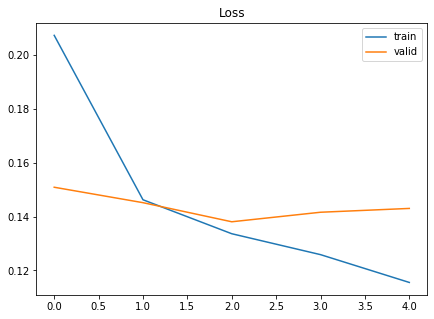

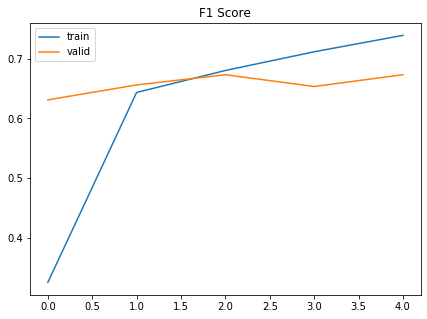

Best F1 score  [0.6734478456961903, 4]


In [70]:
import matplotlib.pyplot as plt
import json
%matplotlib inline

with open('model/history_train.json', 'r') as f:
    history = json.loads(f.read())
    
train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
train_f1 = [l['f1'] for l in history['train']]
valid_f1 = [l['f1'] for l in history['valid']]

plt.figure(figsize=(7,5))
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.title('F1 Score')
plt.plot(train_f1, label='train')
plt.plot(valid_f1, label='valid')
plt.legend()
plt.show()

print('Best F1 score ', max([[l['f1'], idx] for idx, l in enumerate(history['valid'])]))